# 1-step Forecasting with linear and non-linear models

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import utils

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [2]:
# Loading alcohol data
train_df, test_df, data_raw_list = utils.load_alcohol()

combined_data = []

for i in range(len(train_df)):
    train = train_df[i]
    test = test_df[i]
    # Combine both train and test sets since the initial split was 50/50
    combined = pd.concat([train, test])
    # Sort by date
    combined['start'] = pd.to_datetime(combined['start'])
    combined = combined.sort_values(by='start')
    combined_data.append(combined)

combined_data[0].head()

,Unnamed: 0,ID,start,finish,drinks,comfortable,stressed,down,calm,pressure,...,cosT.1,sinT.1,cos2T.1,sin2T.1,cosW.1,sinW.1,dayvar.1,beepvar.1,filter.1,consec.1
0,1,1,2018-02-06 16:20:00,2/6/2018 16:22,3,7.382609,-9.817391,10.843478,-37.791304,6.173913,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1,4,0,1
31,2,1,2018-02-06 18:54:00,2/6/2018 18:58,0,14.382609,47.182609,7.843478,7.208696,10.173913,...,0.892979,0.450098,0.594823,0.803857,0.997777,0.066647,1,5,0,2
1,3,1,2018-02-06 20:08:00,2/6/2018 20:22,0,15.382609,12.182609,10.843478,20.208696,18.173913,...,0.418660,0.908143,-0.649448,0.760406,0.986795,0.161973,1,6,0,3
2,4,1,2018-02-06 22:29:00,2/6/2018 22:46,0,21.382609,-5.817391,-2.156522,8.208696,5.173913,...,0.108867,0.994056,-0.976296,0.216440,0.978277,0.207302,1,7,0,4
36,5,1,2018-02-07 10:52:00,2/7/2018 11:23,0,-11.617391,5.182609,0.843478,-24.791304,-4.826087,...,0.043619,-0.999048,-0.996195,-0.087156,0.777930,0.628351,2,1,0,7


In [3]:
# Loading covid data
covid_train_x_list, covid_test_x_list, covid_train_y_list, covid_test_y_list = utils.patients_covid()

covid_train_x_list[0].head()

55
Patient included in study:
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 48, 49, 50, 52, 53, 54, 55, 58, 59, 63, 64, 65, 66, 68, 70, 71, 72, 74, 75, 77]


,Relax_lag,Irritable_lag,Worry_lag,Nervous_lag,Future_lag,Anhedonia_lag,Tired_lag,Hungry_lag,Alone_lag,Angry_lag,Social_offline_lag,Social_online_lag,Music_lag,Procrastinate_lag,Outdoors_lag,C19_occupied_lag,C19_worry_lag,Home_lag,beepvar_lag
105,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,4.0,2.0,3.0,1.0,2.0,2.0,5.0,1.0
111,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,2.0,2.0,5.0,3.0
109,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0
102,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,4.0,2.0
107,2.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0,1.0,1.0,3.0,3.0,5.0,3.0


## 1. Idiographic Models Regression

In [4]:
# Predict craving

# Make own splits
def prepare_data_own(idx, combined_list, random_state):
    # print('Patient ID:', combined_list[idx].iloc[0]['ID'])
    X = combined_list[idx].drop(combined_list[idx].columns[range(0, 24)], axis=1).fillna(0)
    y = combined_list[idx]['craving']

    return train_test_split(X, y, test_size=0.3, random_state=random_state)


# Split into dependent/independent features
def prepare_data(idx, train_list, test_list):
    # print('Patient ID:', train_list[idx]['ID'][0])

    X_train = train_list[idx].drop(train_list[idx].columns[range(0, 61)], axis=1).fillna(0)
    y_train = train_list[idx]['craving']
    X_test = test_list[idx].drop(test_list[idx].columns[range(0, 61)], axis=1).fillna(0)
    y_test = test_list[idx]['craving']

    return X_train, X_test, y_train, y_test

### 1.1 Elastic-Net Regression

In [5]:
X_train, X_test, y_train, y_test = prepare_data(1, train_list=train_df, test_list=test_df)


# Train an elastic-net model
# Tests sets here are fore testing purposes
def elastic_net(train_x, train_y, test_x, test_y, vis):
    # Standardize data
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)

    # Train model with 5-fold cross-validation
    l1_ratios = np.arange(0.01, 0.6, 0.05)
    elastic_reg = lm.ElasticNetCV(alphas=np.arange(0.01, 20, 0.05), l1_ratio=l1_ratios, cv=5, max_iter=100000,
                                  fit_intercept=True)
    elastic_reg.fit(X_train_loc, train_y)
    y_predicted_test = elastic_reg.predict(X_test_loc)
    # print('--- Elastic-Net Results ---')
    # print()
    # Show results for current test set if vis is set to True
    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)

    return elastic_reg


m = elastic_net(X_train, y_train, X_test, y_test, True)

R_squared: 0.3105248292112299
MSE: 415.92726079626027
RMSE: 20.394294809977133
MAE: 16.71060148405697


### 1.2 Linear SVM Regression

In [6]:
def linear_svm(train_x, train_y, test_x, test_y, vis, params):
    # Standardize data
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)

    # Train over the hyperparameter grid with 5-fold CV
    clf = GridSearchCV(estimator=LinearSVR(), param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
    clf.fit(X_train_loc, train_y)
    # best_params = clf.best_params_
    # print(best_params)
    y_predicted_test = clf.predict(X_test_loc)

    # print('--- Linear-SVM Results ---')
    # print()
    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return clf


param = [
    {'C': np.arange(0.1, 4, 0.1),
     'epsilon': np.arange(6, 7, 0.1),
     'loss': ['epsilon_insensitive'],
     'fit_intercept': [True],
     'max_iter': [10000]}]

m = linear_svm(X_train, y_train, X_test, y_test, True, param)

R_squared: 0.33564960762582075
MSE: 400.770688512245
RMSE: 20.01925794109874
MAE: 16.088758133762482


### 1.3 K-NN Regression

In [7]:
# k-Nearest Neighbors Model
def knn_reg(train_x, train_y, test_x, test_y, vis):
    params = [
        {'weights': ['uniform', 'distance'],
         'n_neighbors': np.arange(2, 20, 1)}]

    # Train with 5-fold CV
    clf = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, scoring='neg_mean_absolute_error', cv=5)
    clf.fit(train_x, train_y)

    y_predicted_test = clf.predict(test_x)

    mse, rmse, mae = utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return mse, rmse, mae


m = knn_reg(X_train, y_train, X_test, y_test, True)

R_squared: 0.1254204616378809
MSE: 527.591836734694
RMSE: 22.969367355995985
MAE: 17.183673469387752


### 1.4 XGBoost Regression

In [8]:
def xgboost_reg(train_x, train_y, test_x, test_y, vis):
    # Very simple models work better here, since there are few data points
    # Hyperparameter grid
    params = [
        {'objective': ['reg:squarederror'],
         'n_estimators': [3, 5, 7, 10, 20, 30],
         'eval_metric': ['rmse'],
         'max_depth': np.arange(1, 8, 1)}]

    # Train a model with 5-fold CV
    reg_xgb = GridSearchCV(xgb.XGBRegressor(), params, n_jobs=5, cv=5, scoring='neg_mean_squared_error')
    reg_xgb.fit(train_x, train_y)

    # print(reg_xgb.best_params_)
    y_predicted_test = reg_xgb.predict(test_x)

    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return reg_xgb


m = xgboost_reg(X_train, y_train, X_test, y_test, True)

R_squared: 0.23298253953909775
MSE: 462.70480044617017
RMSE: 21.510574154265854
MAE: 17.261206285039783


### 1.5 Random Forests

In [9]:

# Function to train a random forests model
def random_forests(train_x, train_y, test_x, test_y, vis):
    # Hyperparameter grid
    grid = [
        {'n_estimators': [25, 50, 70, 100],
         'max_features': ['auto', 'sqrt'],
         'max_depth': [3, 5, 10, 15],
         'min_samples_split': [2, 4, 6],
         'min_samples_leaf': [1],
         'bootstrap': [True]}]

    # Train with 5-fold CV
    rf = GridSearchCV(RandomForestRegressor(), param_grid=grid, cv=5, n_jobs=5, scoring='neg_mean_squared_error')
    rf.fit(train_x, train_y)
    y_predicted_test = rf.predict(test_x)
    # print(rf.best_params_)

    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)

    return rf


m = random_forests(X_train, y_train, X_test, y_test, True)

R_squared: 0.2822293416904683
MSE: 432.99656962132116
RMSE: 20.808569619782162
MAE: 17.204171540477663


### 1.6 3-Layer LSTM RNN

In [10]:
import keras.layers as layer
from keras.models import Sequential


# Train a NN with 3 LSTM units
def lstm_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.LSTM(40, return_sequences=True),
        layer.Dropout(0.25),
        layer.LSTM(units=25, return_sequences=True),
        layer.Dropout(0.20),
        layer.LSTM(units=10, return_sequences=False),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=45, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.numpy().flatten(), show=vis)

    return model


m = lstm_rnn(X_train, y_train, X_test, y_test, True)

R_squared: 0.048840278303379336
MSE: 573.7889838330525
RMSE: 23.953892874291906
MAE: 20.29241277091295


### 1.7 1-Layer LSTM RNN

In [11]:
# Train a NN with 1 LSTM unit
def one_lstm_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.Bidirectional(layer.LSTM(32, return_sequences=True)),
        layer.Dropout(0.25),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=45, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.numpy().flatten(), show=vis)

    return model


m = one_lstm_rnn(X_train, y_train, X_test, y_test, True)

R_squared: 0.09823193595123914
MSE: 543.9933686433726
RMSE: 23.323665420413075
MAE: 19.234732745140366


### 1.8 Gated Recurrent Unit (GRU) Network

In [12]:
# Train a NN with GRU units
def gru_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.GRU(40, return_sequences=True),
        layer.Dropout(0.25),
        layer.GRU(units=25, return_sequences=True),
        layer.Dropout(0.20),
        layer.GRU(units=10, return_sequences=False),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=50, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.numpy().flatten(), show=vis)

    return model


m = gru_rnn(X_train, y_train, X_test, y_test, True)

R_squared: 0.20810131250992614
MSE: 477.71444987510324
RMSE: 21.8566797541416
MAE: 18.226911941695974


### 2.1 Evaluating Performance on Entire Dataset (Alcohol Data)

In [13]:
import warnings

warnings.filterwarnings("ignore")


# Function to evaluate the models on the 'Alcohol' dataset
def evaluate_models(train_list, test_list):
    assert len(train_list) == len(test_list)
    # Lists to hold the metrics for all patients and models
    mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
    rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
    mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

    patient_ids = []
    # Write out the results to a text file
    f = open("output_idiographic_a.txt", "a")
    f.write('- - - PER INDIVIDUAL RESULTS - - -\n')
    for x in range(len(train_list)):
        # Build and evaluate a model for every single patient
        train_x, test_x, train_y, test_y = prepare_data(x, train_list=train_list, test_list=test_list)
        # Elastic-Net (baseline)
        elastic = elastic_net(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, elastic.predict(utils.standardize(test_x).fillna(0)), False)
        # Elastic-Net metrics
        patient_ids.append(train_list[x]['ID'][0])
        mse_elastic.append(mse)
        rmse_elastic.append(rmse)
        mae_elastic.append(mae)

        f.write("Patient ID: %s\n" % train_list[x]['ID'][0])
        f.write('\n')
        f.write('--- Elastic-Net ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # Linear-SVM

        params = [
            {'C': np.arange(0.1, 4, 0.1),
             'epsilon': np.arange(6, 7, 0.1),
             'loss': ['epsilon_insensitive'],
             'fit_intercept': [True],
             'max_iter': [10000]}]

        svm = linear_svm(train_x, train_y, test_x, test_y, False, params)
        mse, rmse, mae = utils.eval_results(test_y, svm.predict(utils.standardize(test_x).fillna(0)), False)
        # Linear-SVM metrics
        mse_svm.append(mse)
        rmse_svm.append(rmse)
        mae_svm.append(mae)

        f.write('--- Linear-SVM ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # XGBoost Regression
        xgboost = xgboost_reg(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, xgboost.predict(test_x), False)
        # XGBoost metrics
        mse_xgb.append(mse)
        rmse_xgb.append(rmse)
        mae_xgb.append(mae)

        f.write('--- XGBoost ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # RF
        rf = random_forests(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, rf.predict(test_x), False)
        # RF metrics
        mse_rf.append(mse)
        rmse_rf.append(rmse)
        mae_rf.append(mae)

        f.write('--- Random Forests ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 3-Layer RNN
        test_x_val = utils.standardize(test_x).fillna(0).values
        test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
        lstm = lstm_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, lstm(test_x_val).numpy().flatten(),
                                            False)
        # LSTM metrics
        mse_lstm.append(mse)
        rmse_lstm.append(rmse)
        mae_lstm.append(mae)

        f.write('--- LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 1-Layer RNN
        lstm_one = one_lstm_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, lstm_one(test_x_val).numpy().flatten(), False)
        # LSTM metrics
        mse_one_lstm.append(mse)
        rmse_one_lstm.append(rmse)
        mae_one_lstm.append(mae)

        f.write('--- 1-LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # GRU RNN
        gru = gru_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, gru(test_x_val).numpy().flatten(), False)

        # GRU metrics
        mse_gru.append(mse)
        rmse_gru.append(rmse)
        mae_gru.append(mae)

        f.write('--- GRU RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

    f.close()
    # Print out the average metrics for all models
    print('---- Elastic-Net Results ----')
    utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
    print('---------------------------------')
    print('---- Linear SVM Results ----')
    utils.average_metrics(mse_svm, rmse_svm, mae_svm)
    print('---------------------------------')
    print('---- XGBoost Results ----')
    utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
    print('---------------------------------')
    print('---- Random Forest Results ----')
    utils.average_metrics(mse_rf, rmse_rf, mae_rf)
    print('---------------------------------')
    print('---- LSTM Results ----')
    utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
    print('---------------------------------')
    print('---- 1-LSTM Results ----')
    utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
    print('---------------------------------')
    print('---- GRU Results ----')
    utils.average_metrics(mse_gru, rmse_gru, mae_gru)
    print('---------------------------------')

    print('Included patient list:')
    print(patient_ids)

    # For the box-plot later
    rmse_overall = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
    n = len(rmse_rf)
    model_names = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
        '1-Layer LSTM'] * n + ['GRU'] * n
    dataset = ['Alcohol'] * len(model_names)
    mae_overall = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

    return mae_overall, rmse_overall, model_names, dataset


mae_alcohol, rmse_alcohol, models_alcohol, data_alcohol = evaluate_models(train_df, test_df)

---- Elastic-Net Results ----
Average MSE: 284.289072940186
Average RMSE: 14.771363649360774
Average MAE: 10.985510678456176
---------------------------------
---- Linear SVM Results ----
Average MSE: 274.5015705068991
Average RMSE: 14.649677063534172
Average MAE: 10.707141252389354
---------------------------------
---- XGBoost Results ----
Average MSE: 278.86923810306496
Average RMSE: 14.943659338749356
Average MAE: 10.79137345313305
---------------------------------
---- Random Forest Results ----
Average MSE: 263.66524080881163
Average RMSE: 14.543151067921437
Average MAE: 10.603196035329534
---------------------------------
---- LSTM Results ----
Average MSE: 295.18094579755433
Average RMSE: 15.53540562214411
Average MAE: 10.401631659175946
---------------------------------
---- 1-LSTM Results ----
Average MSE: 316.8323249162967
Average RMSE: 16.116175904148967
Average MAE: 10.873618869266101
---------------------------------
---- GRU Results ----
Average MSE: 285.8391172882765
Av

### 2.2 Evaluating Performance on Entire Dataset (COVID-19 Data)

In [14]:
import warnings

warnings.filterwarnings("ignore")


# Function to evaluate the models on the COVID-19 dataset
def evaluate_models(covid_train_x, covid_test_x, covid_train_y, covid_test_y):
    # Lists to hold the metrics for all patients and models
    mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
    rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
    mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

    # Write the results to a text file
    f = open("output_idiographic_c.txt", "a")
    f.write('- - - PER INDIVIDUAL RESULTS - - -\n')

    for z in range(len(covid_train_x)):
        # Build and evaluate a model for every single patient

        # Elastic-Net (baseline)
        elastic = elastic_net(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z],
                                            elastic.predict(utils.standardize(covid_test_x[z]).fillna(0)),
                                            False)

        # Elastic-Net metrics
        mse_elastic.append(mse)
        rmse_elastic.append(rmse)
        mae_elastic.append(mae)

        f.write("Patient ID: %s\n" % z)
        f.write('\n')
        f.write('--- Elastic-Net ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # Linear-SVM

        params = [
            {'C': np.arange(0.1, 2, 0.1),
             'epsilon': np.arange(0, 0.5, 0.1),
             'loss': ['epsilon_insensitive'],
             'fit_intercept': [True],
             'max_iter': [10000]}]

        svm = linear_svm(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False, params)
        mse, rmse, mae = utils.eval_results(covid_test_y[z],
                                            svm.predict(utils.standardize(covid_test_x[z]).fillna(0)),
                                            False)
        # Linear-SVM metrics
        mse_svm.append(mse)
        rmse_svm.append(rmse)
        mae_svm.append(mae)

        f.write('--- Linear-SVM ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # XGBoost Regression
        xgb_covid = xgboost_reg(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z], xgb_covid.predict(covid_test_x[z]), False)
        # XGBoost metrics
        mse_xgb.append(mse)
        rmse_xgb.append(rmse)
        mae_xgb.append(mae)

        f.write('--- XGBoost ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # RF
        rf_covid = random_forests(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z], rf_covid.predict(covid_test_x[z]), False)
        # RF metrics
        mse_rf.append(mse)
        rmse_rf.append(rmse)
        mae_rf.append(mae)

        f.write('--- Random Forests ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 3-Layer RNN
        test_x_val = utils.standardize(covid_test_x[z]).fillna(0).values
        test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
        lstm_covid = lstm_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z],
                                            lstm_covid(test_x_val).numpy().flatten(),
                                            False)
        # LSTM metrics
        mse_lstm.append(mse)
        rmse_lstm.append(rmse)
        mae_lstm.append(mae)

        f.write('--- LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 1-Layer RNN
        lstm1_covid = one_lstm_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z],
                                            lstm1_covid(test_x_val).numpy().flatten(),
                                            False)
        # LSTM metrics
        mse_one_lstm.append(mse)
        rmse_one_lstm.append(rmse)
        mae_one_lstm.append(mae)

        f.write('--- 1-LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # GRU RNN
        gru = gru_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y[z], gru(test_x_val).numpy().flatten(), False)

        # GRU metrics
        mse_gru.append(mse)
        rmse_gru.append(rmse)
        mae_gru.append(mae)

        f.write('--- GRU RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

    f.close()
    # Print out the average metrics for every model
    print('---- Elastic-Net Results ----')
    utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
    print('---------------------------------')
    print('---- Linear SVM Results ----')
    utils.average_metrics(mse_svm, rmse_svm, mae_svm)
    print('---------------------------------')
    print('---- XGBoost Results ----')
    utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
    print('---------------------------------')
    print('---- Random Forest Results ----')
    utils.average_metrics(mse_rf, rmse_rf, mae_rf)
    print('---------------------------------')
    print('---- LSTM Results ----')
    utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
    print('---------------------------------')
    print('---- 1-LSTM Results ----')
    utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
    print('---------------------------------')
    print('---- GRU Results ----')
    utils.average_metrics(mse_gru, rmse_gru, mae_gru)
    print('---------------------------------')

    # For the box-plot later
    rmse_overall = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
    n = len(rmse_rf)
    model_names = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
        '1-Layer LSTM'] * n + ['GRU'] * n
    dataset = ['COVID-19'] * len(model_names)
    mae_overall = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

    return mae_overall, rmse_overall, model_names, dataset


mae_covid, rmse_covid, models_covid, data_covid = evaluate_models(covid_train_x_list, covid_test_x_list,
                                                                  covid_train_y_list,
                                                                  covid_test_y_list)

---- Elastic-Net Results ----
Average MSE: 0.518294044921122
Average RMSE: 0.6817393435818496
Average MAE: 0.5335545617893568
---------------------------------
---- Linear SVM Results ----
Average MSE: 0.830927839293906
Average RMSE: 0.8617693198765266
Average MAE: 0.6731610756394789
---------------------------------
---- XGBoost Results ----
Average MSE: 0.5760141886631155
Average RMSE: 0.7194641296945431
Average MAE: 0.5401325396713146
---------------------------------
---- Random Forest Results ----
Average MSE: 0.47838558147358745
Average RMSE: 0.6598676745818489
Average MAE: 0.5099747024338436
---------------------------------
---- LSTM Results ----
Average MSE: 0.6894981631080481
Average RMSE: 0.7930313774485571
Average MAE: 0.6043650362295009
---------------------------------
---- 1-LSTM Results ----
Average MSE: 0.9168847056186058
Average RMSE: 0.9186038847623406
Average MAE: 0.7135913296797931
---------------------------------
---- GRU Results ----
Average MSE: 0.6275399440666

In [37]:
# Generate a box-plot for the RMSE values
mae = mae_alcohol + mae_covid
rmse = rmse_alcohol + rmse_covid
models = models_alcohol + models_covid
dataset_names = data_alcohol + data_covid

dictionary = {'MAE': mae, 'RMSE': rmse, 'Model': models, 'Dataset': dataset_names}
df = pd.DataFrame(data=dictionary)
# boxplot = sns.catplot(x='Model', y='RMSE', col='Dataset',
# data=df, kind="box",
# height=4, aspect=.7)
# boxplot = sns.boxplot(data=df.loc[df['Dataset'] == 'COVID-19'], y='RMSE', x='Model', palette="Set3")
# boxplot.set(title='RMSE Values For All Individuals', ylabel='RMSE')
df.to_csv('idiographic.csv')

In [5]:
idiographic = pd.read_csv('idiographic.csv', index_col=0)
nomothetic = pd.read_csv('nomothetic.csv', index_col=0)

nomothetic_col = ['Nomothetic'] * len(nomothetic)
idiographic_col = ['Idiographic'] * len(idiographic)

idiographic['Type'] = idiographic_col
nomothetic['Type'] = nomothetic_col

results = pd.concat([idiographic, nomothetic]).reset_index(drop=True)

results_alcohol = results.loc[results['Dataset'] == 'Alcohol']
results_covid = results.loc[results['Dataset'] == 'COVID-19']

results_alcohol.to_csv('alcohol_results.csv')
results_covid.to_csv('covid_results.csv')
results_alcohol.head()

,MAE,RMSE,Model,Dataset,Type
0,3.479327,4.199605,Elastic Net,Alcohol,Idiographic
1,16.710601,20.394295,Elastic Net,Alcohol,Idiographic
2,15.730987,19.551551,Elastic Net,Alcohol,Idiographic
3,5.205935,10.152362,Elastic Net,Alcohol,Idiographic
4,9.624731,11.705399,Elastic Net,Alcohol,Idiographic


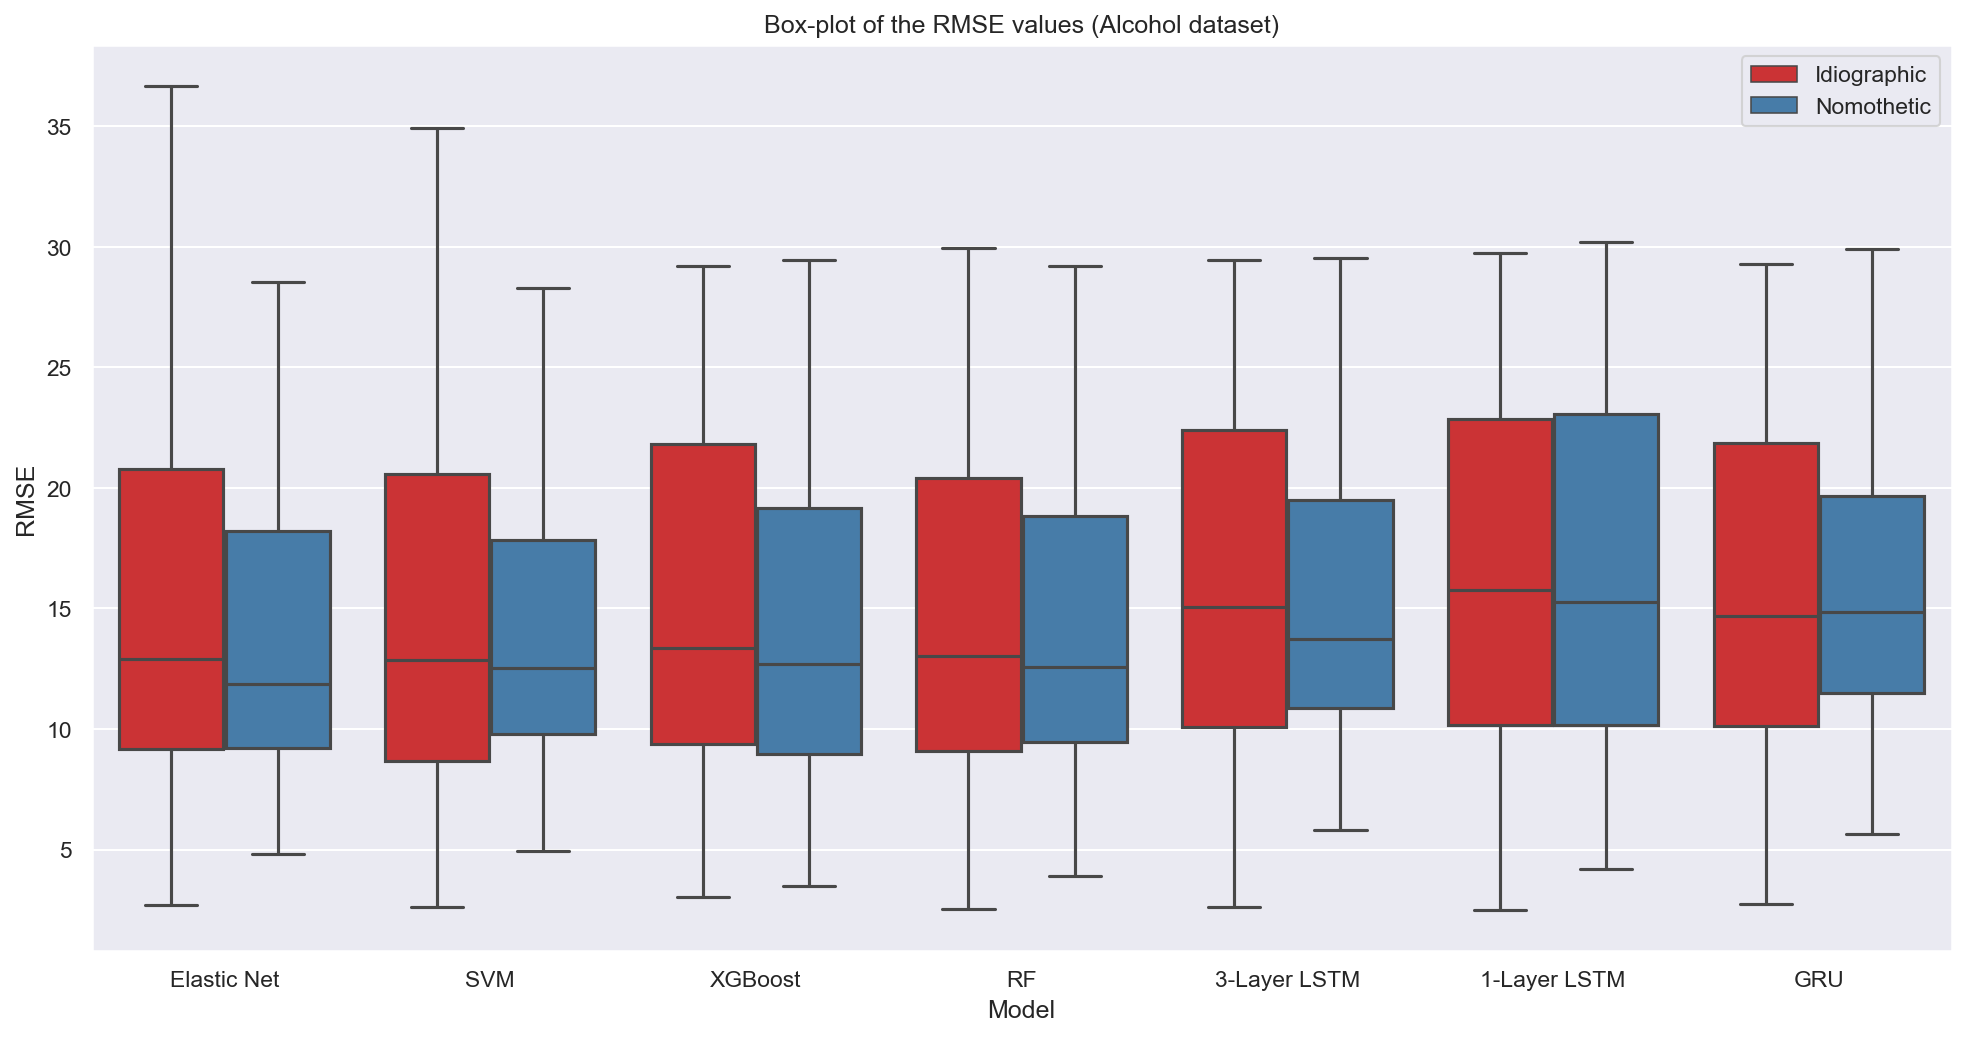

In [22]:
# Box-plot for the alcohol dataset
g = results_alcohol.loc[results_alcohol['Type'] == 'Idiographic']
# g = g.loc[g['Model'] == 'Elastic Net']
# print(g['RMSE'].mean())
# boxplot = sns.catplot(x='Model', y='RMSE', col='Dataset',
# data=df, kind="box",
# height=4, aspect=.7)
boxplot = sns.boxplot(data=results_alcohol, y='RMSE', x='Model', palette="Set1", hue='Type')
boxplot.set(title='Box-plot of the RMSE values (Alcohol dataset)', ylabel='RMSE')
boxplot.legend(loc='upper right')
# boxplot.figure.savefig('boxplot_alcohol.png')

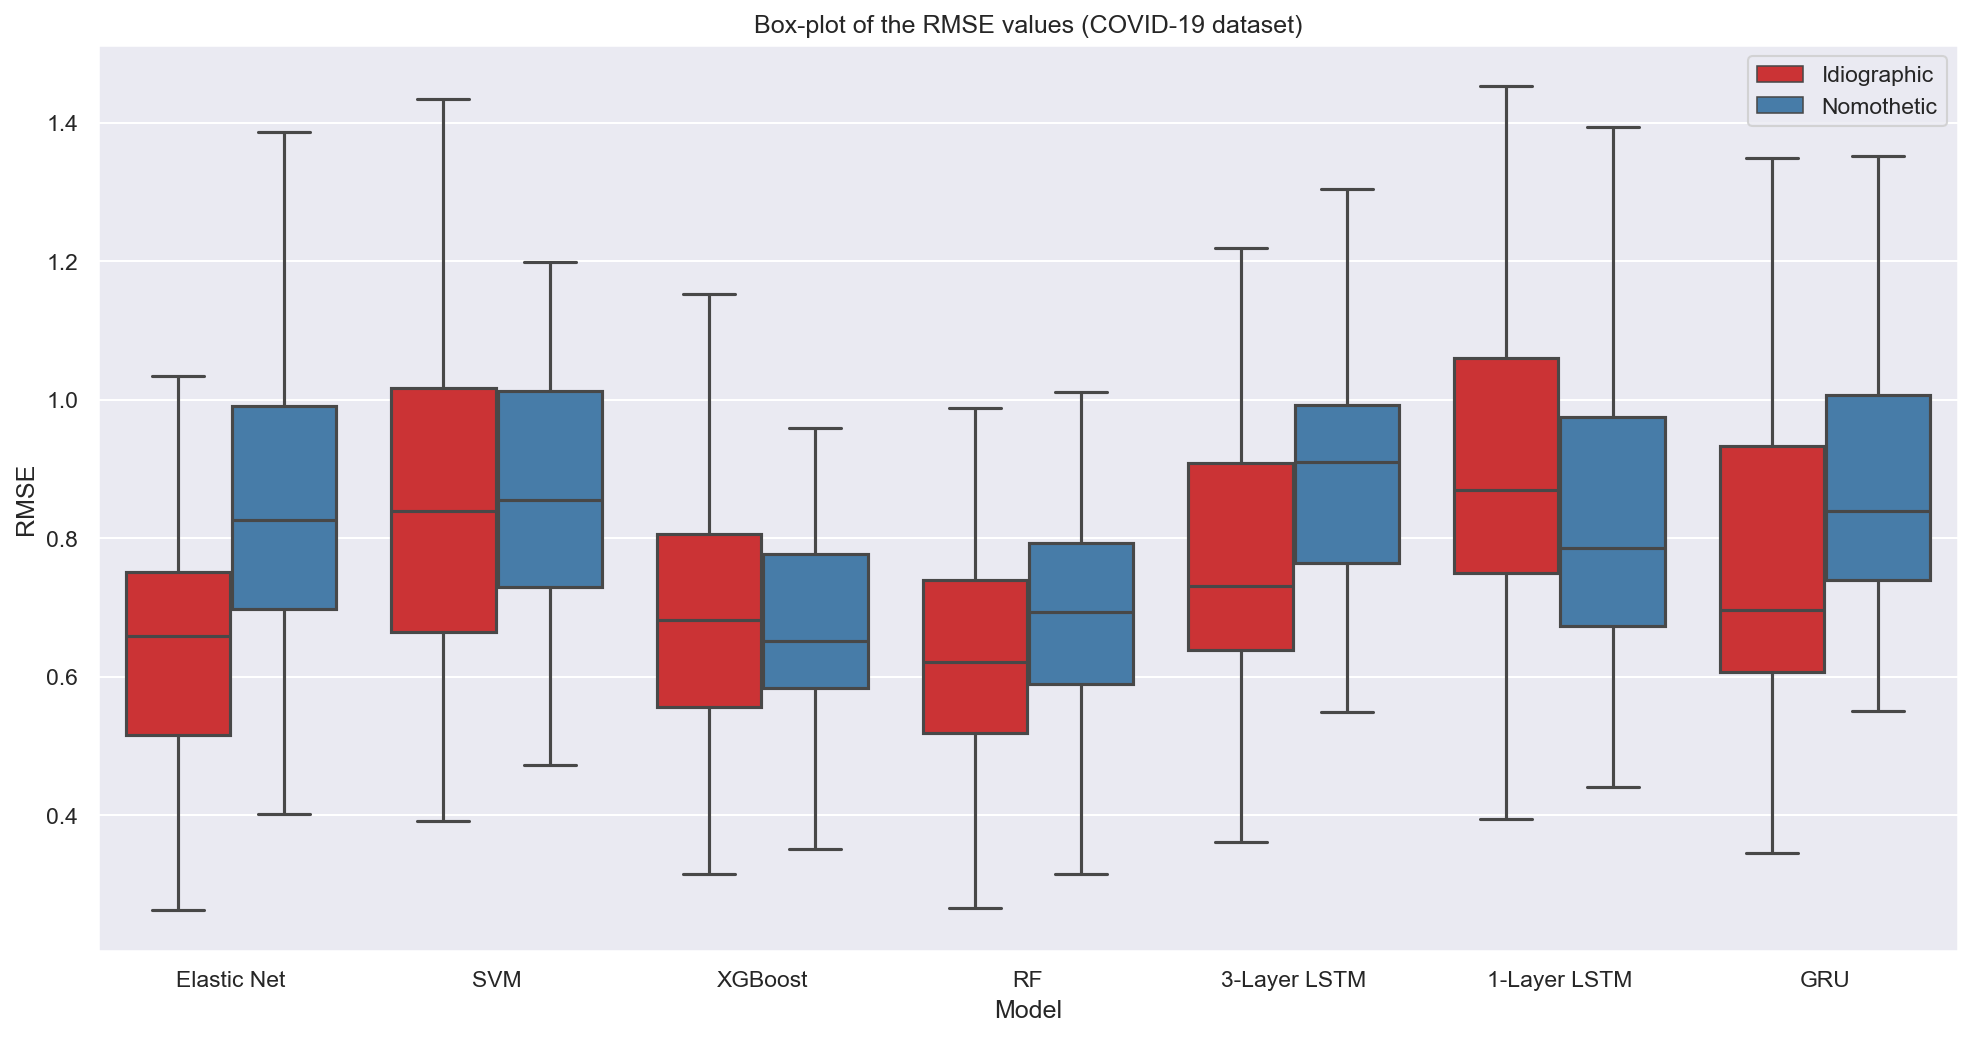

In [23]:
boxplot_2 = sns.boxplot(data=results_covid, y='RMSE', x='Model', palette="Set1", hue='Type', showfliers=False)
boxplot_2.set(title='Box-plot of the RMSE values (COVID-19 dataset)', ylabel='RMSE')
boxplot_2.legend(loc='upper right')
#boxplot_2.figure.savefig('boxplot_covid.png')

In [28]:
from collections import Counter

idiographic_alcohol = results_alcohol.loc[results_alcohol['Type'] == 'Idiographic']
# print(idiographic_alcohol.groupby(['Model']).std())
nomothetic_alcohol = results_alcohol.loc[results_alcohol['Type'] == 'Nomothetic']
# print(nomothetic_alcohol.groupby(['Model']).std())
idiographic_covid = results_covid.loc[results_covid['Type'] == 'Idiographic']
# print(idiographic_covid.groupby(['Model']).std())
nomothetic_covid = results_covid.loc[results_covid['Type'] == 'Nomothetic']
print(nomothetic_covid.groupby(['Model']).std())


# print(nomothetic_covid.groupby(['Model']).mean())

def best_for_individual(dataframe, metric):
    df_list = [d for _, d in dataframe.groupby(['Model'])]

    min_rmse_list = []
    min_name_list = []

    for x in range(len(df_list[0])):
        name = ''
        min_val = 100
        for d in df_list:
            row = d.iloc[x]

            if row[metric] < min_val:
                min_val = row[metric]
                name = row['Model']

        min_name_list.append(name)
        min_rmse_list.append(min_val)

    proportion = Counter(min_name_list)
    # proportion = proportion.values() / len(min_name_list)

    print(proportion)
    print([(i, proportion[i] / len(min_name_list) * 100.0) for i in proportion])


best_for_individual(nomothetic_covid, 'MAE')

                   MAE      RMSE
Model                           
1-Layer LSTM  0.319090  0.320073
3-Layer LSTM  0.297943  0.298469
Elastic Net   0.305790  0.298863
GRU           0.307540  0.302173
RF            0.190267  0.214605
SVM           0.302458  0.299471
XGBoost       0.184103  0.214521
Counter({'XGBoost': 21, 'RF': 17, 'GRU': 8, '3-Layer LSTM': 3, '1-Layer LSTM': 3, 'SVM': 2, 'Elastic Net': 1})
[('RF', 30.909090909090907), ('XGBoost', 38.18181818181819), ('Elastic Net', 1.8181818181818181), ('GRU', 14.545454545454545), ('3-Layer LSTM', 5.454545454545454), ('1-Layer LSTM', 5.454545454545454), ('SVM', 3.6363636363636362)]


### Nomothethic Approach In separate notebook